In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForMaskedLM
from optimum.bettertransformer import BetterTransformer

tqdm.pandas()

In [2]:
compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
flavor_content = pd.read_csv('data/CompoundsFlavor.csv', header=0, index_col=0)
flavors = pd.read_csv('data/Flavor.csv', header=0, index_col=0)

ontology_content = pd.read_csv('data/CompoundOntologyTerm.csv', header=0, index_col=0)
ontology = pd.read_csv('data/OntologyTerm.csv', header=0, index_col=0)

health_content = pd.read_csv('data/CompoundsHealthEffect.csv', header=0, index_col=0)
health = pd.read_csv('data/HealthEffect.csv', header=0, index_col=0)

/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_29482/335688320.py:1: DtypeWarning: Columns (3,4,5,6,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)
/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_29482/335688320.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ontology_content = pd.read_csv('data/CompoundOntologyTerm.csv', header=0, index_col=0)


In [7]:
cur_content = flavor_content
cur_df = flavors
id_col = 'flavor_id'

### Compound Filtering

In [4]:
# # Only keep relevant entries
# content = content[content['source_type'] == 'Compound']
# content = content[content['food_id'].isin(foods.index)]
# content = content[content['source_id'].isin(compounds.index)]

# # We just keep the observations that use the `mg/100g` unit for concentration measurement
# content = content[content['orig_unit'].isin(['mg/100g', 'mg/100 g'])]
# content.dropna(subset=['orig_content'], inplace=True)

# # Only keep the compounds that are shared amongst the selected foods of interest
# relevant_compounds = content['source_id'].unique()
# compounds = compounds[compounds.index.isin(relevant_compounds)]

# # Only keep compounds that have a valid smiles string
smiles = compounds.dropna(subset=['cas_number', 'superklass'])

In [5]:
smiles = compounds.merge(cur_content, left_index=True, right_on="compound_id")
smiles = smiles[smiles['compound_id'] != 29634]

In [6]:
len(smiles)

10239

<Axes: >

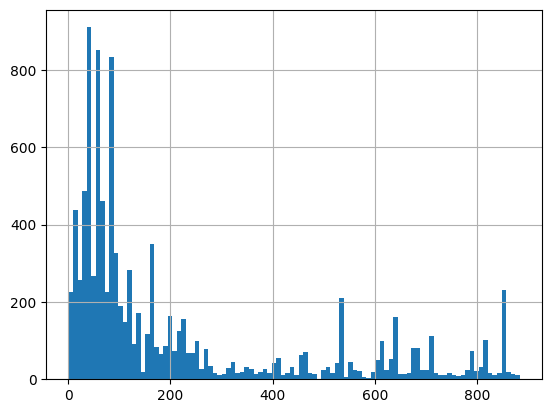

In [8]:
smiles[id_col].hist(bins=100)

In [9]:
# Only keep compounds that have a valid smiles string
smiles = smiles.dropna(subset=['cas_number', id_col])
top_terms = smiles.groupby([id_col])[id_col].count()
top_terms.nlargest(20)
# cutoff_terms = top_terms[top_terms <= 800].nlargest(20)

flavor_id
81     570
44     561
59     491
33     275
123    234
54     224
531    203
848    195
18     164
162    150
643    150
21     138
50     126
98     123
68     115
34     113
37     100
17      98
95      94
814     94
Name: flavor_id, dtype: int64

In [10]:
top_terms = top_terms[top_terms < 200]
targets = top_terms.nlargest(10)

In [11]:
t = top_terms.to_frame()
final_df = t.merge(cur_df, left_index=True, right_index=True)
final_df.nlargest(10, id_col)

# final_df.groupby('health_effect_id')['health_effect_id'].sum()
# t['name'] = cutoff_terms.index.map(lambda x: ontology.loc[x, 'term'])
# t

,flavor_id,name,flavor_group,category,created_at,updated_at,creator_id,updater_id
848,195,waxy,NaN,odor,2011-11-25 20:32:47 UTC,2011-11-25 20:32:47 UTC,NaN,NaN
18,164,fatty,fatty,odor,2011-10-02 06:10:06 UTC,2011-10-02 06:10:06 UTC,NaN,NaN
162,150,fresh,NaN,odor,2011-10-02 06:12:20 UTC,2011-10-02 06:12:20 UTC,NaN,NaN
643,150,odorless,NaN,odor,2011-11-25 20:32:08 UTC,2011-11-25 20:32:08 UTC,NaN,NaN
21,138,spicy,spicy,odor,2011-10-02 06:10:06 UTC,2011-10-02 06:10:06 UTC,NaN,NaN
50,126,citrus,citrus,odor,2011-10-02 06:10:11 UTC,2011-10-02 06:10:11 UTC,NaN,NaN
98,123,nutty,nutty,odor,2011-10-02 06:10:16 UTC,2011-10-02 06:10:16 UTC,NaN,NaN
68,115,earthy,earthy,odor,2011-10-02 06:10:13 UTC,2011-10-02 06:10:13 UTC,NaN,NaN
34,113,rose,floral,odor,2011-10-02 06:10:10 UTC,2011-10-02 06:10:10 UTC,NaN,NaN
37,100,balsam,balsamic,odor,2011-10-02 06:10:10 UTC,2011-10-02 06:10:10 UTC,NaN,NaN


In [ ]:
h = final_df[final_df['ontology_term_id'] <= 500]
h = h.sort_values(['ontology_term_id'], ascending=False) \
        .groupby('level')['ontology_term_id'] \
        .nlargest(10)

h

In [ ]:
targets = h.loc[5].index
targets

In [14]:
smiles = smiles[smiles[id_col].isin(targets.index)]
# smiles = smiles[smiles['ontology_term_id'].isin(cutoff_terms.index)]
smiles['effect_name'] = smiles[id_col].apply(lambda x: cur_df.loc[x, 'name'])

In [15]:
smiles = smiles.dropna(subset=['cas_number', id_col])

## SMILES-BERT
In this section, I will use a bert-model from huggingface that has been trained on SMILES sequence data to 
extract embeddings for each compound in my dataset. We will then use these embeddings to perform clustering
analysis to see if we can get any interesting clusters by visualization.

In [16]:
# Download the smiles-bert model from hugging-face
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
model_better = BetterTransformer.transform(model, keep_original_model=True)

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


In [18]:
def get_embeddings(smiles_string: str):
    """
    This functions will tokenizes the raw smiles string and runs the bert model 
    on the tokenized input to produce logits that are generally used for a self-masking cloze task.
    However, I will extract the hidden state at the penultimate layer and use the CLS token embedding 
    for downstream clustering
    """
    try:
        inputs = tokenizer(smiles_string, return_tensors="pt")    
        cls_token_id = tokenizer.cls_token_id
        hidden_st = model_better(**inputs, output_hidden_states=True).hidden_states    
        return hidden_st[-1][0, cls_token_id, :]
    except:
        print(smiles_string)
        return None

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [19]:
smiles_embeds = smiles['cas_number'].progress_apply(get_embeddings)

  0%|                                                  | 0/1374 [00:00<?, ?it/s]/Users/stephenlu/anaconda3/envs/ml/lib/python3.11/site-packages/optimum/bettertransformer/models/encoder_models.py:301: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343657571/work/aten/src/ATen/NestedTensorImpl.cpp:179.)
  hidden_states = torch._nested_tensor_from_mask(hidden_states, ~attention_mask)
100%|███████████████████████████████████████| 1374/1374 [01:29<00:00, 15.31it/s]


In [20]:
smiles_embeds.dropna(inplace=True)

In [21]:
test = [x.cpu().detach().numpy() for x in smiles_embeds]

In [22]:
test[0].shape

(768,)

In [77]:
smiles['embeddings'] = [x.cpu().detach().numpy() for x in smiles_embeds]

In [79]:
smiles = smiles.drop(columns=['moldb_iupac', 'description', 'moldb_inchikey', 'moldb_inchi', 'moldb_smiles', 'moldb_mono_mass'])

In [80]:
smiles.to_csv('data/smile_embeddings.csv')

## Dimension Reduction

First, let's attempt some dimension reduction and manifold learning techniques to obtain unbiased visualizations of the SMILES strings grouped by relevant categories such as compound flavor, health effects, and protein function ontology. If the SMILES-BERT model did a good job of learning meaningful representations of the data, then we would expect some form of dilineation between these categories.

### PCA using scikit-learn

In [81]:
smiles = pd.read_csv('data/smile_embeddings.csv', header=0, index_col=0)

In [113]:
import torch
from sklearn.decomposition import PCA

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
target_col = "effect_name"

In [29]:
# X = [np.fromstring(x, dtype=np.float32, count=768) for x in smiles['embeddings']]
X = test
y = np.array(smiles[target_col].fillna('unknown'))

In [30]:
# These are the kingdom labels that we will use for clustering
target_names, y = np.unique(y, return_inverse=True)

In [31]:
target_names

array(['balsam', 'citrus', 'earthy', 'fatty', 'fresh', 'nutty',
       'odorless', 'rose', 'spicy', 'waxy'], dtype=object)

In [349]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

In [350]:
# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.32598365 0.10001198]


In [351]:
values = list(range(len(target_names)))
# colors = ["navy", "turquoise", "darkorange"]
cmap = plt.colormaps['tab10']
colors = cmap.colors[:len(target_names)]
lw = 1.2

In [352]:
plot_title = "PCA of compound health effects (top10b)"
plot_filename = "results/plots/pca_compound_health_effects_top10b.png"

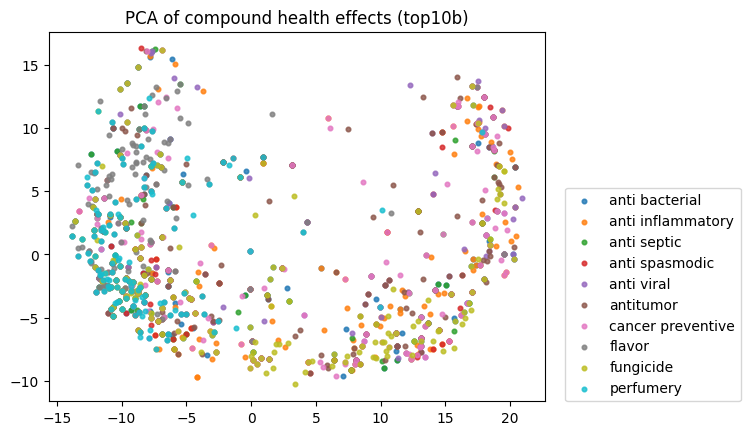

In [353]:
plt.figure()
for color, i, target_name in zip(colors, values, target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], s=10, color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc=(1.04, 0), shadow=False, scatterpoints=1)
plt.title(plot_title)
plt.savefig(plot_filename, bbox_inches='tight')

## TSNE using scikit-learn

In [354]:
from sklearn.manifold import TSNE

In [355]:
t_sne = TSNE(
    n_components=2,
    perplexity=100,
    init="random",
    n_iter=1000,
    random_state=0,
)

In [356]:
X_r = t_sne.fit_transform(np.array(X))

In [357]:
plot_title = "t-SNE of compound health effects (top10b)"
plot_filename = "results/plots/tsne_compound_health_effects_top10b.png"

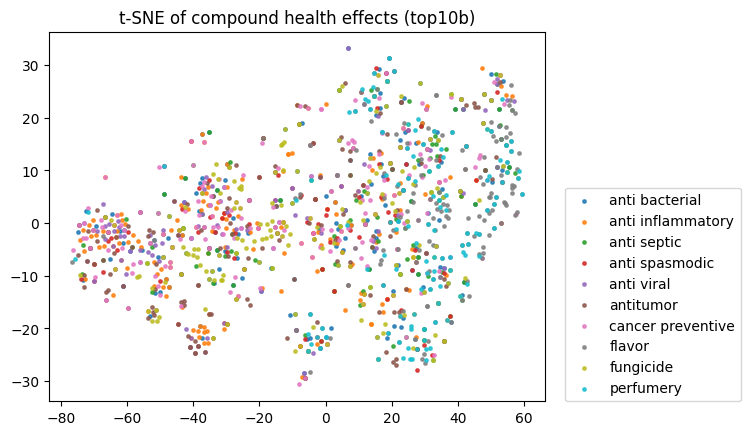

In [358]:
plt.figure()
for color, i, target_name in zip(colors, values, target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], s=5, color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc=(1.04, 0), shadow=False, scatterpoints=1)
plt.title(plot_title)
plt.savefig(plot_filename, bbox_inches='tight')

# Unsupervised Learning

Next, let's try some unsupervised learning techniques to further elucidate what kind of distribution the SMILES-BERT model has learnt. Let's start with some clustering methods like k-means. 

In [37]:
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans

np.random.seed(0)

batch_size = 45

In [45]:
K = range(2, 20)
fits = []
score = []


for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X)
    
    # append the model to fits
    fits.append(model)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(X, model.labels_, metric='euclidean'))

In [46]:
score

[0.1266157,
 0.089115284,
 0.09897466,
 0.10790971,
 0.11909374,
 0.11167176,
 0.118161574,
 0.11573216,
 0.11075615,
 0.10950672,
 0.117008045,
 0.12831855,
 0.1270474,
 0.12660666,
 0.117773265,
 0.12072043,
 0.12007593,
 0.12353139]